In [1]:
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.4 MB/s eta 0:00:00


In [2]:
import Bio.PDB as pdb

# Предсказание ротамеров угла $\chi_1$ в зависимости от окружения

In [3]:
import json
import pandas as pd
import numpy as np

## Запустите следующую клетку. Будет случайно выбрана аминокислота, для которой вы будете проводить исследование

In [ ]:
amacid_names = ['ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'HIS', 'ILE', 'LEU',
                'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']

print(f"Моя аминокислота - {np.random.choice(amacid_names)}")

Моя аминокислота - TYR


## Загрузите <a href="https://yadi.sk/d/FeLl5KYfjbhHgA?w=1">отсюда</a> соответствующий файл. Далее мы будем работать с ним.

# Часть 1. Анализ значений угла $\chi_1$

## Задание 1.1. Откроем загруженный файл. Посмотрим на колонки:

In [23]:
dpath = "TYR_data.csv"

In [24]:
df = pd.read_csv(dpath)

In [ ]:
df.head()

,Unnamed: 0,pbd_indx,phi,psi,tau,alpha,ind_from_start,ind_from_end,sec_structure,is_tail,...,gamma14,alpha15,beta15,gamma15,alpha16,beta16,gamma16,alpha17,beta17,gamma17
0,0,2BO5,-148.001357,-67.992231,117.157701,-110.703325,11,108,-,0,...,114.580795,36.661160,67.461259,54.652780,14.056945,43.857109,100.998151,19.703593,63.315198,73.225830
1,1,2BO5,-55.714933,-49.908315,90.977755,37.753339,17,102,H,0,...,69.076968,107.687638,168.415868,85.773413,16.502680,92.882349,76.732688,26.697398,58.605741,80.229164
2,2,2BO5,-78.342760,-18.608555,87.632632,83.964880,22,97,H,0,...,118.832041,31.302429,121.968191,72.152814,111.938707,42.869942,115.972377,89.464734,120.572756,88.181731
3,3,2BO5,-85.870711,-30.408628,95.016856,57.634714,58,61,T,0,...,46.561656,33.672983,92.764160,97.069248,37.070288,24.167924,96.798978,39.278673,71.786531,51.187381
4,4,2BW2,-114.553991,-32.869655,94.356042,72.594777,5,134,E,0,...,58.612176,36.047283,14.467107,83.900206,21.524376,60.654675,109.154373,22.350609,61.600486,70.386124


In [ ]:
df["pbd_indx"].nunique(), df.shape

(4028, (27306, 301))

In [ ]:
list(df.columns)

Эта таблица содержит информацию о сэмплах одной аминокислоты. Для каждого сэмпла известны:
- Значения всех двугранных углов $\chi$;
- Значения $\phi, \psi, \alpha$ (двугранный угол, построенный по 4 последовательным атомам $C_\alpha$);
- Данные о 17 ближайших пространственных соседях:
    - $\phi, \psi$;
    - Названия аминокислот;
    - Расстояние до целевой аминокислоты по $C_\alpha$;
    - Химические / физикохимические характеристики соседа: группы и точные значения некоторых характеристик;
    - Дополнительные геометрические характеристики (относительно целевой аминокислоты).

## Задание 1.2. Постройте гистограмму значений $\chi_1$ из этой таблицы. Какие ротамеры выделяются на этой гистограмме?

In [6]:
import matplotlib.pyplot as plt

In [ ]:
df = df[~np.isnan(df["chi_1"])]

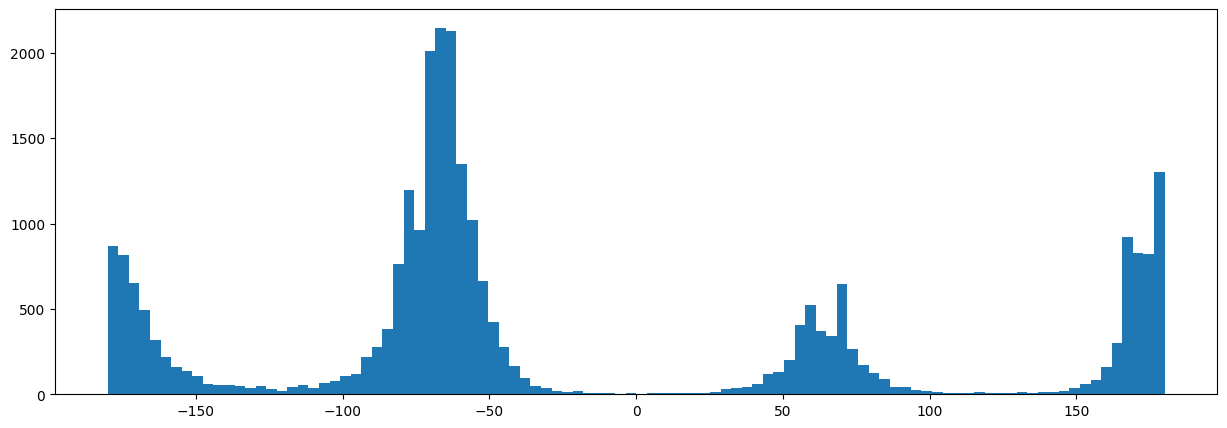

In [ ]:
plt.figure(figsize=(15,5))

plt.hist(df["chi_1"], bins=100)

plt.show()

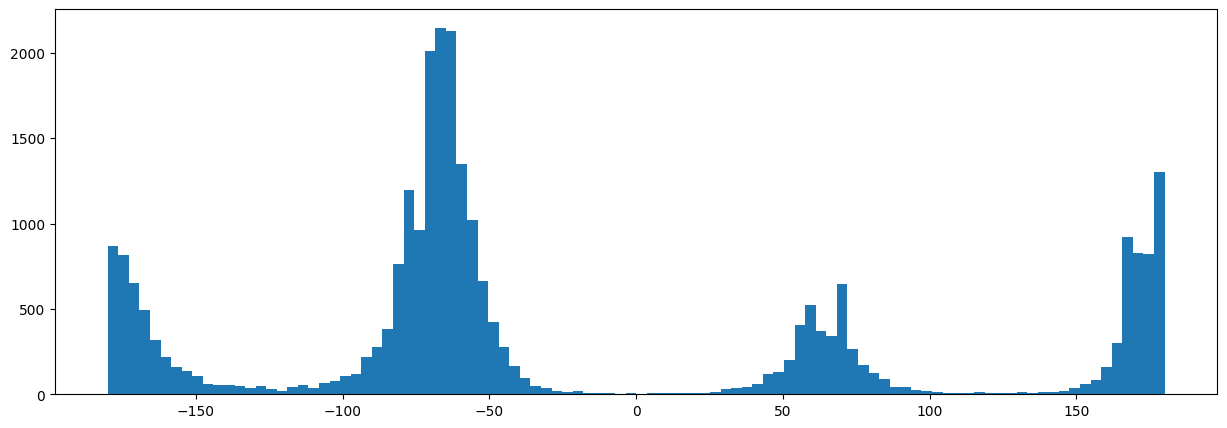

In [ ]:
plt.figure(figsize=(15,5))

hs, xs, *_ = plt.hist(df["chi_1"], bins=100)

plt.show()

calculate value

In [ ]:
len(hs), len(xs)

(100, 101)

In [ ]:
xs = (xs[1:] + xs[:-1]) / 2

In [ ]:
rotamer_inds = [i for i in range(3, len(hs))
                if np.all(hs[i - 3:i]<hs[i]) and np.all(hs[i+1:i +4]<hs[i])]
print(rotamer_inds)

[31, 68, 99]


In [ ]:
xs[rotamer_inds]

array([-66.59300479,  66.59961651, 178.19343435])

Занесите обнаруженные ротамеры в список rotamers:

In [ ]:
rotamers = [-60, 60, 180]

## Задание 1.3. Давайте разберемся, как можно дискретизировать значения (разделить их на классы). Реализуйте функцию get_class(value, rotamers), которая возвращает индекс ротамера, к которому относится значение value.

**Комментарий**: стоит вычислять расстояние от value до каждого значения из rotamers. Но не забудьте, что с точки зрения окружности $-\pi$ и $\pi$ - одно и то же!

In [ ]:
def get_class(value, rotamers):
    diffs = np.abs(np.array(rotamers) - value)
    diffs = np.minimum(diffs, 360 - diffs)
    return np.argmin(diffs)

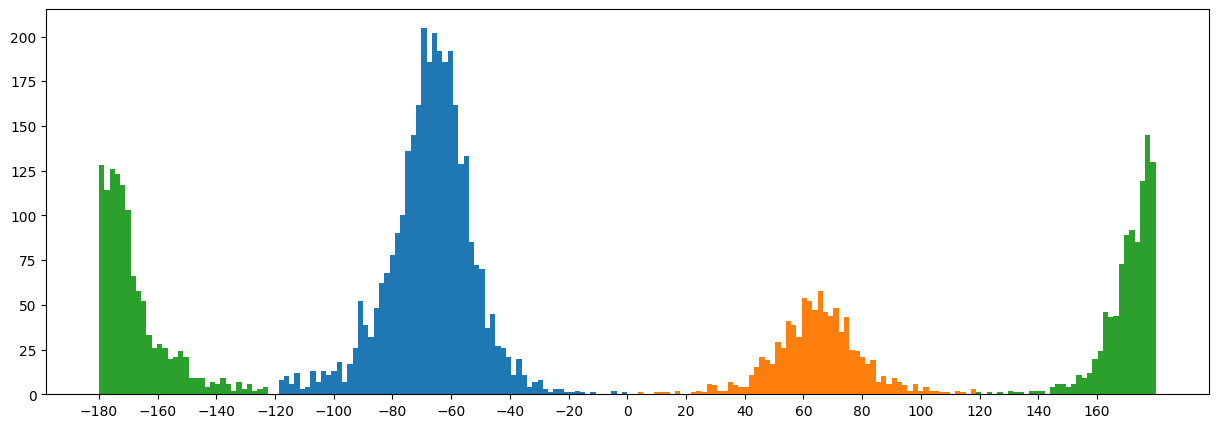

In [ ]:
plt.figure(figsize=(15,5))
classes = [get_class(val, rotamers) for val in df["chi_1"]]

for i in np.unique(classes):
    plt.hist(df["chi_1"].values[classes == i], bins=200, range=(-180, 180))

plt.xticks(np.arange(-180, 180, 20))
plt.show()

## Задание 1.4. Теперь мы умеем делить значения $\chi_1$ на классы, т.е. можем понять, к какому ротамеру относится то или иное значение.
Реализуем первую часть подхода Dunbrack. Шаги:
- Разделить карту Рамачандрана на блоки $20 x 20$. Для каждого блока нужно найти те сэмплы из выборки, которые входят в него.
- Для всех найденных сэмплов нужно получить индексы классов; после этого выбрать класс, встречающийся чаще всего, и сохранить его в соответствующую ячейку матрицы **most_common_rotamers**.
    - Если получилось меньше 10 значений для некоторого блока, нужно получить наиболее частый класс для всей выборки.

In [ ]:
all_rots = [get_class(val, rotamers) for val in df["chi_1"]]
df["rotamer"] = all_rots
all_un_rots, all_un_cnts = np.unique(all_rots, return_counts=True)

most_common = all_un_rots[np.argmax(all_un_cnts)]

In [ ]:
most_common #must be -60

0

In [ ]:
most_common_rotamers = np.full((18, 18), np.nan)
for phi_ind in range(18):
    phi_st = -180 + 20 * phi_ind
    phi_end = -180 + 20 * (phi_ind + 1)
    for psi_ind in range(18):
        psi_st = -180 + 20 * psi_ind
        psi_end = -180 + 20 * (psi_ind + 1)

        subdf = df[(df["phi"] >= phi_st) & (df["phi"] < phi_end) &
                   (df["psi"] >= psi_st) & (df["psi"] < psi_end)]
        if len(subdf) < 10:
          most_common_rotamers[psi_ind, phi_ind] = -1 #most_common
          continue
        un_rotamers, counts = np.unique(subdf["rotamer"].values,
                                       return_counts=True)
        best_rotamer_ind = np.argmax(counts)
        best_rotamer = un_rotamers[best_rotamer_ind]
        most_common_rotamers[psi_ind, phi_ind] = best_rotamer

In [ ]:
subdf

,Unnamed: 0,pbd_indx,phi,psi,tau,alpha,ind_from_start,ind_from_end,sec_structure,is_tail,...,alpha15,beta15,gamma15,alpha16,beta16,gamma16,alpha17,beta17,gamma17,rotamer
1481,1481,1E5U,160.039658,176.913883,147.193544,-77.331799,181,5,-,0,...,137.263402,131.245555,122.965070,99.921371,36.019976,104.944477,48.297466,79.902094,137.824885,1
3812,3812,1UEY,178.254941,170.965431,146.527919,-107.175874,86,40,E,0,...,124.595655,106.534381,42.279523,12.927538,89.465233,100.222842,57.077012,141.986970,115.156525,1
6037,6037,1X4C,179.693149,169.628805,145.735816,156.184865,96,11,-,0,...,134.579397,165.475936,82.654735,5.562817,52.224378,91.659520,48.261321,15.143317,101.202414,2


Отобразите получившуюся матрицу с помощью plt.imshow:

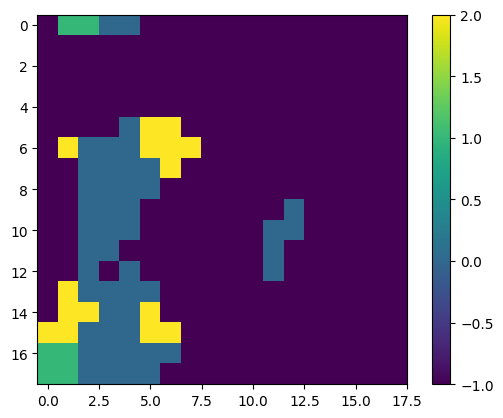

In [ ]:
plt.imshow(most_common_rotamers)

plt.colorbar()
plt.show()

Какие выводы можно сделать на основании изображения выше? Можно ли сказать, что какой-то ротамер характерен для определенной вторичной структуры?

# $\rightarrow$ Ваши идеи 🙂

## Задание 1.5. А насколько вообще состоятелен подход к поиску пересечений, основанный на энергии van der Waals?

Давайте возьмем достаточно длинный белок $1Z87$, откроем его и изучим:

In [ ]:
import Bio.PDB as pdb

In [ ]:
path = pdb.PDBList().retrieve_pdb_file("1z87",
                                       file_format="pdb")
struct = pdb.PDBParser().get_structure("s", path)

Получите 0-ую цепочку этого белка, найдите в ней индексы всех цистеинов (CYS):

In [ ]:
chain = struct[0].child_list[0]
residues = chain.child_list
cys_inds = [i for i in range(len(residues)) if residues[i].resname == "CYS"]

In [ ]:
cys_inds

[15, 218, 231]

Выберите первый найденный цистеин. Будем менять для него угол $\chi_1$ и смотреть, как будет меняться энергия ван дер Ваальса при взаимодействии с другими атомами.

$U_{LJ} = 4 \cdot \epsilon \cdot [(\frac{r_{min}}{r})^{12} - 2 \cdot (\frac{r_{min}}{r})^6]$

In [ ]:
lj_coeffs = pd.read_csv("lennard-jones_12-6.csv", delimiter="\t")
lj_coeffs.head()

,atom_pair,reqm,eps
0,C-C,4,"0,15"
1,C-N,"3,75","0,155"
2,C-O,"3,6","0,173"
3,C-S,4,"0,173"
4,C-H,3,"0,055"


In [ ]:
def van_der_Waals(d, d_m, eps):
    return  4 * eps * (((d_m / d) ** 12) - 2 * ((d_m / d) ** 6))

<function matplotlib.pyplot.show(close=None, block=None)>

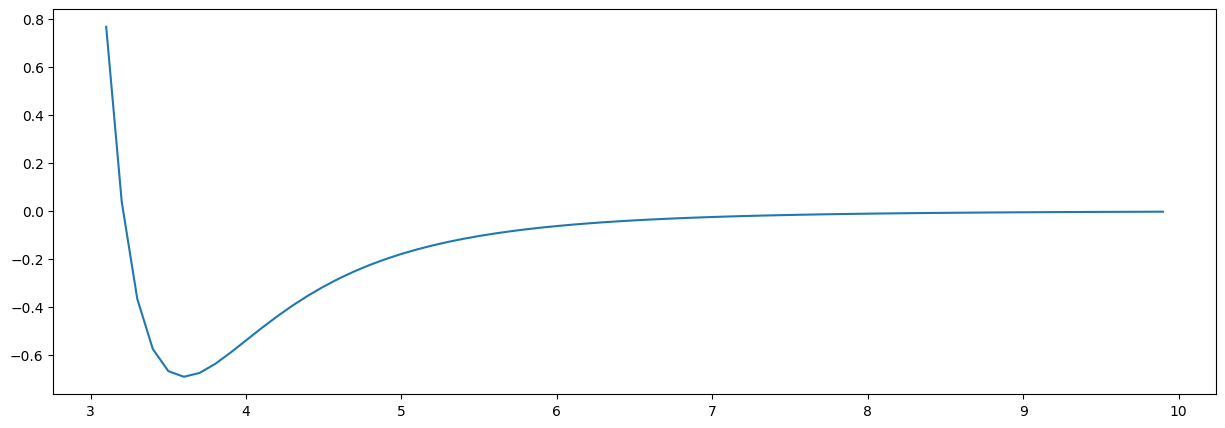

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
xs = np.arange(3.1,10, 0.1)
plt.plot(xs, van_der_Waals(xs, 3.6, 0.173))
plt.show

Изменяя двугранный угол в пределах $[-\pi, \pi)$:
- Вычислите новые координаты атома SG у цистеина. Для этого можно воспользоваться функциями из файла geometry.py (из первого ДЗ).
- После получения координат, их можно присвоить с помощью метода:

    residue["CG"].set_coord(new_cg1_coord)
- После этого вычислите суммарную энергию ван дер Ваальса взаимодействия со всеми другими атомами белка.

In [ ]:
from geometry import *

Для удобства сделаем словарь из таблицы с коэффициентами потенциала типа Леннарда-Джонса:

In [ ]:
lj_coeffs = {row[0]: {"d_min": float(row[1].replace(",", ".")),
                      "eps": float(row[2].replace(",", "."))} for row in lj_coeffs.values}
lj_coeffs

{'C-C': {'d_min': 4.0, 'eps': 0.15},
 'C-N': {'d_min': 3.75, 'eps': 0.155},
 'C-O': {'d_min': 3.6, 'eps': 0.173},
 'C-S': {'d_min': 4.0, 'eps': 0.173},
 'C-H': {'d_min': 3.0, 'eps': 0.055},
 'N-C': {'d_min': 3.75, 'eps': 0.155},
 'N-N': {'d_min': 3.5, 'eps': 0.16},
 'N-O': {'d_min': 3.35, 'eps': 0.179},
 'N-S': {'d_min': 3.75, 'eps': 0.179},
 'N-H': {'d_min': 2.75, 'eps': 0.057},
 'O-C': {'d_min': 3.6, 'eps': 0.173},
 'O-N': {'d_min': 3.35, 'eps': 0.179},
 'O-O': {'d_min': 3.2, 'eps': 0.2},
 'O-S': {'d_min': 3.6, 'eps': 0.2},
 'O-H': {'d_min': 2.6, 'eps': 0.063},
 'S-C': {'d_min': 4.0, 'eps': 0.173},
 'S-N': {'d_min': 3.75, 'eps': 0.179},
 'S-O': {'d_min': 3.6, 'eps': 0.2},
 'S-S': {'d_min': 4.0, 'eps': 0.2},
 'S-H': {'d_min': 3.0, 'eps': 0.063},
 'H-C': {'d_min': 3.0, 'eps': 0.055},
 'H-N': {'d_min': 2.75, 'eps': 0.057},
 'H-O': {'d_min': 2.6, 'eps': 0.063},
 'H-S': {'d_min': 3.0, 'eps': 0.063},
 'H-H': {'d_min': 2.0, 'eps': 0.02}}

In [ ]:
def calc_vdw_w_residue(ref_residue, residue):
    ref_atoms = [at
                 for at in ref_residue.child_list
                 if at not in ["C", "N", "CA", "CB", "O"] and at.element[0] != "H"]
    atoms = [at
             for at in residue.child_list
             if at.element[0] != "H"]

    ds, d_ms, epses = [], [], []
    for at1 in ref_atoms:
        for at2 in atoms:
            pair = "{}-{}".format(at1.element, at2.element)
            ds += [at1 - at2]
            d_ms += [lj_coeffs[pair]["d_min"]]
            epses += [lj_coeffs[pair]["eps"]]

    ds =    np.array(ds)
    d_ms =  np.array(d_ms)
    epses = np.array(epses)

    return van_der_Waals(ds, d_ms, epses).sum()


In [ ]:
calc_vdw_w_residue(chain[2], chain[3])

157461.58689638547

In [ ]:
chi1_vals = np.arange(-np.pi, np.pi, np.pi/10) #np.pi/30

cys_residue = residues[cys_inds[0]]

chi1_true = pdb.calc_dihedral(cys_residue["N"].get_vector(),
                              cys_residue["CA"].get_vector(),
                              cys_residue["CB"].get_vector(),
                              cys_residue["SG"].get_vector(),
                             )
planar = pdb.calc_angle(cys_residue["CA"].get_vector(),
                      cys_residue["CB"].get_vector(),
                      cys_residue["SG"].get_vector())
bond = cys_residue["SG"] - cys_residue["CB"]
prev_atoms = np.array([cys_residue["N"].coord,
                       cys_residue["CA"].coord,
                       cys_residue["CB"].coord,
                      ])

vdw_vals = []

for chi1 in chi1_vals:
    new_coord = place_next_dihedral_atom(prev_atoms, chi1, planar, bond)
    cys_residue["SG"].set_coord(new_coord)

    chi_vdw_sum = 0
    for i, res in enumerate(chain):
      if i == cys_inds[0]:
        continue
      chi_vdw_sum += calc_vdw_w_residue(cys_residue, res)
    vdw_vals.append(chi_vdw_sum)

Постройте график для получившихся значений энергии. Какой вывод можно сделать из него?

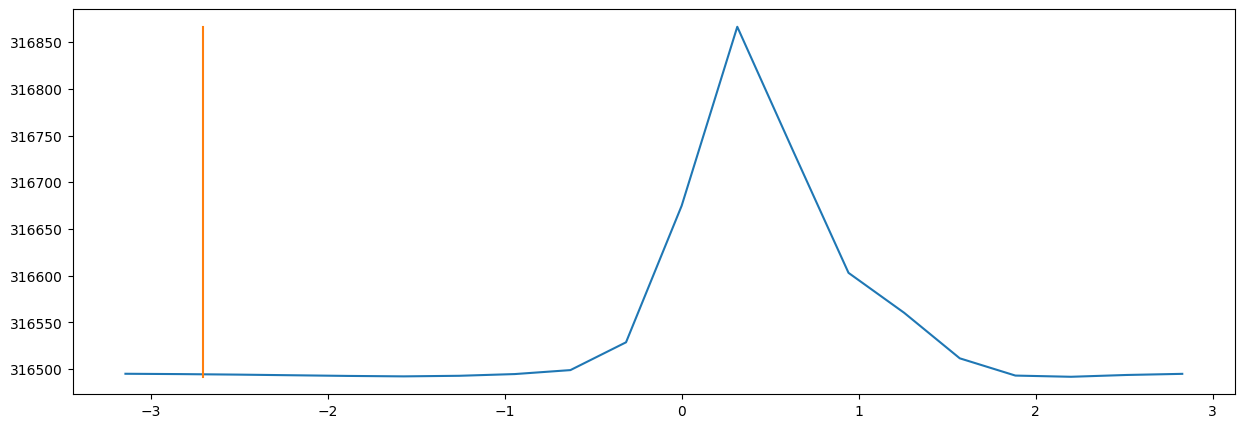

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(chi1_vals, vdw_vals)

plt.plot([chi1_true, chi1_true], [min(vdw_vals), max(vdw_vals)])

plt.show()

# Часть 2. Предсказание ротамеров $\chi_1$

В этой части Вам предстоит применить методы Машинного Обучения (деревья решений) к задаче предсказания ротамеров Вашей аминокислоты.

## Задание 2.1. Вернемся к датасету из части 1. Добавьте колонку chi_class, которая получается преобразованием значений из колонки chi_1 к классам.

In [36]:
df = pd.read_csv(dpath)

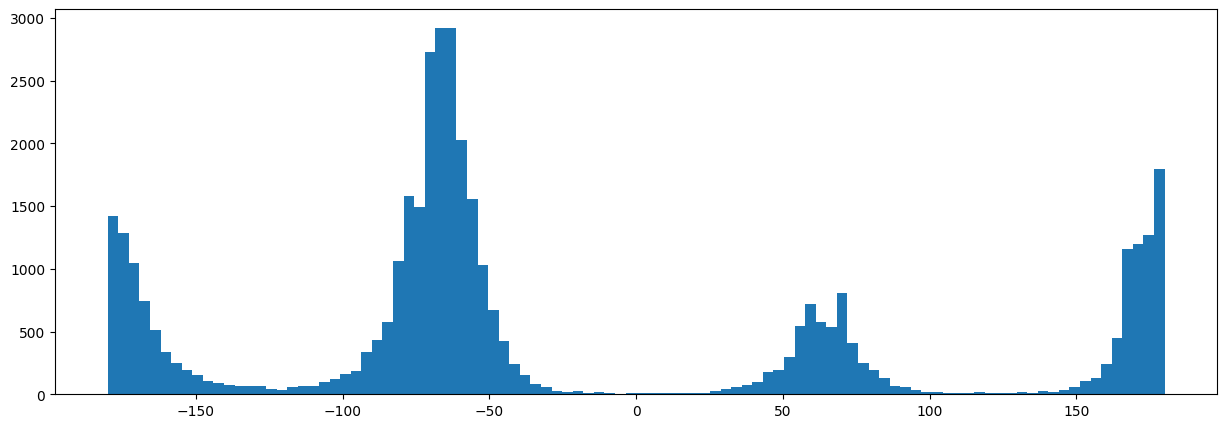

In [26]:
#гистограмма значений  𝜒1
df = df[~np.isnan(df["chi_1"])]

plt.figure(figsize=(15,5))
plt.hist(df["chi_1"], bins=100)
plt.show()

In [37]:
#обнаруженные ротамеры занесем в список rotamers:
rotamers = [-60, 60, 180]

In [38]:
#функция get_class(value, rotamers) возвращает индекс ротамера, к которому относится значение value.
def get_class(value, rotamers):
    diffs = np.abs(np.array(rotamers) - value)
    diffs = np.minimum(diffs, 360 - diffs)
    return np.argmin(diffs)

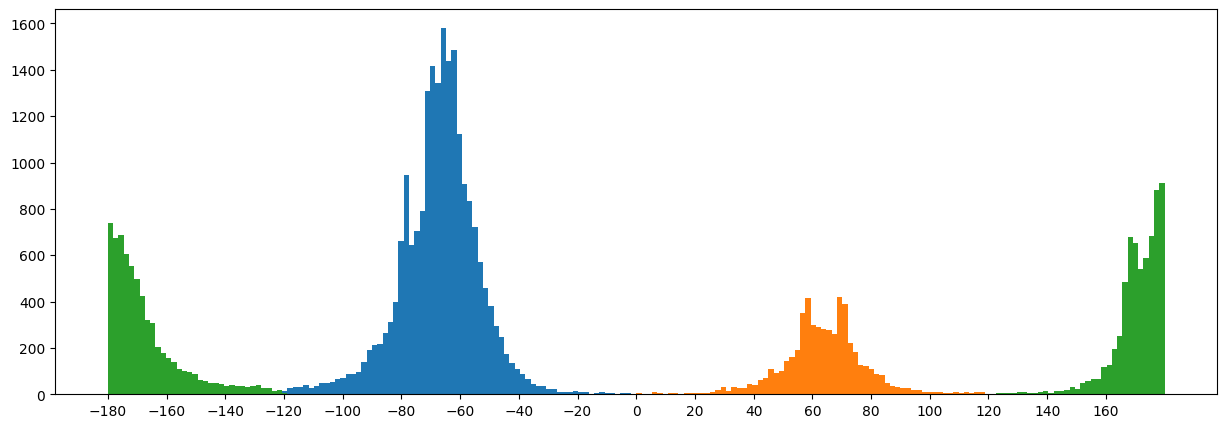

In [39]:
plt.figure(figsize=(15,5))
classes = [get_class(val, rotamers) for val in df["chi_1"]]

for i in np.unique(classes):
    plt.hist(df["chi_1"].values[classes == i], bins=200, range=(-180, 180))

plt.xticks(np.arange(-180, 180, 20))
plt.show()

In [40]:
df['chi_class'] = classes

В колонке chi_class класс, к которому относится значение  𝜒1, т.е. можно понять, к какому ротамеру относится то или иное значение.

## Задание 2.2. Теперь давайте дискретизируем значения $\phi, \psi, \alpha$. Каждому значению из $[-\pi, \pi]$ нужно поставить в соответствие номер блока длиной 20 градусов, в который он попадает.

**Комментарий**: обратите внимание, значения могут быть отрицательными. А номер блока нет 🤔

In [41]:
df['phi']

0       -148.001357
1        -55.714933
2        -78.342760
3        -85.870711
4       -114.553991
            ...    
39766    -66.338163
39767    -76.365674
39768   -125.196882
39769   -114.724414
39770   -136.373749
Name: phi, Length: 39771, dtype: float64

In [42]:
y = df['phi']
phiDiscr = pd.cut(y,bins = 18, labels = ['0', '1','2','3', '4', '5', '6', '7', '8', '9', '10',
                                       '11', '12', '13', '14', '15', '16', '17'])
df['phiDiscr'] = phiDiscr

In [43]:
df['phiDiscr']

0        1
1        6
2        5
3        4
4        3
        ..
39766    5
39767    5
39768    2
39769    3
39770    2
Name: phiDiscr, Length: 39771, dtype: category
Categories (18, object): ['0' < '1' < '2' < '3' ... '14' < '15' < '16' < '17']

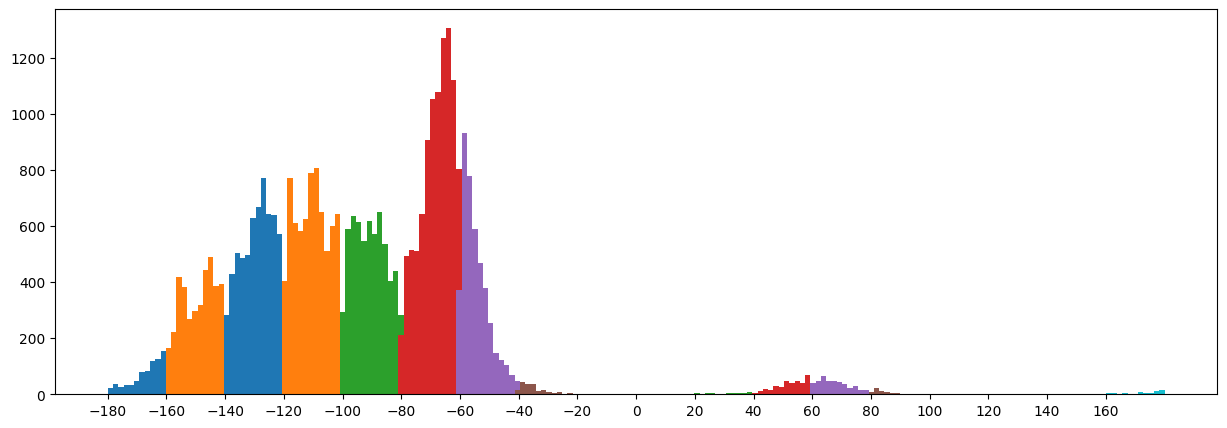

In [44]:
plt.figure(figsize=(15,5))

for i in np.unique(phiDiscr):
    plt.hist(df["phi"].values[phiDiscr == i], bins=200, range=(-180, 180))

plt.xticks(np.arange(-180, 180, 20))
plt.show()

На графике показано, что все значения из [−𝜋,𝜋]  разделены на блоки длиной 20 градусов.

In [ ]:
y =  df['psi']
psiDiscr = pd.cut(y,bins = 18, labels = ['0', '1','2','3', '4', '5', '6', '7', '8', '9', '10',
                                       '11', '12', '13', '14', '15', '16', '17'])
df['psi'] = psiDiscr

y =  df['alpha']
alphaDiscr = pd.cut(y,bins = 18, labels = ['0', '1','2','3', '4', '5', '6', '7', '8', '9', '10',
                                       '11', '12', '13', '14', '15', '16', '17'])
df['alpha'] = alphaDiscr

df['phi'] = phiDiscr
df = df.drop(columns=['phiDiscr'])

Данные о 17 ближайших пространственных соседях тоже дискретизируем

In [46]:
def discr(y):
  return pd.cut(y,bins = 18, labels = ['0', '1','2','3', '4', '5', '6', '7', '8', '9', '10',
                                       '11', '12', '13', '14', '15', '16', '17'])

In [47]:
sele_cols = list(df.columns[12:46])

In [48]:
sele_cols

['n_phi_1',
 'n_psi_1',
 'n_phi_2',
 'n_psi_2',
 'n_phi_3',
 'n_psi_3',
 'n_phi_4',
 'n_psi_4',
 'n_phi_5',
 'n_psi_5',
 'n_phi_6',
 'n_psi_6',
 'n_phi_7',
 'n_psi_7',
 'n_phi_8',
 'n_psi_8',
 'n_phi_9',
 'n_psi_9',
 'n_phi_10',
 'n_psi_10',
 'n_phi_11',
 'n_psi_11',
 'n_phi_12',
 'n_psi_12',
 'n_phi_13',
 'n_psi_13',
 'n_phi_14',
 'n_psi_14',
 'n_phi_15',
 'n_psi_15',
 'n_phi_16',
 'n_psi_16',
 'n_phi_17',
 'n_psi_17']

In [49]:
df[sele_cols] = df[sele_cols].apply(discr)

## Задание 2.3. В датасете есть текстовые признаки! Так как они категориальные, их значения можно поменять на натуральные числа. Пронумеруйте все уникальные значения таких признаков и измените текстовые значения на соответствующие номера.

In [7]:
sel_cols = list(df.select_dtypes(include='object'))

In [50]:
sel_cols

['pbd_indx',
 'sec_structure',
 'n_name_1',
 'n_name_2',
 'n_name_3',
 'n_name_4',
 'n_name_5',
 'n_name_6',
 'n_name_7',
 'n_name_8',
 'n_name_9',
 'n_name_10',
 'n_name_11',
 'n_name_12',
 'n_name_13',
 'n_name_14',
 'n_name_15',
 'n_name_16',
 'n_name_17',
 'n_1_charge_group',
 'n_1_chemical_group',
 'n_1_hydrogen_donor_acceptor_group',
 'n_1_hydropathy_group',
 'n_1_physicochemical_group',
 'n_1_polarity_group',
 'n_1_volume_group',
 'n_2_charge_group',
 'n_2_chemical_group',
 'n_2_hydrogen_donor_acceptor_group',
 'n_2_hydropathy_group',
 'n_2_physicochemical_group',
 'n_2_polarity_group',
 'n_2_volume_group',
 'n_3_charge_group',
 'n_3_chemical_group',
 'n_3_hydrogen_donor_acceptor_group',
 'n_3_hydropathy_group',
 'n_3_physicochemical_group',
 'n_3_polarity_group',
 'n_3_volume_group',
 'n_4_charge_group',
 'n_4_chemical_group',
 'n_4_hydrogen_donor_acceptor_group',
 'n_4_hydropathy_group',
 'n_4_physicochemical_group',
 'n_4_polarity_group',
 'n_4_volume_group',
 'n_5_charge_gro

In [51]:
from sklearn.preprocessing import LabelEncoder
df[sel_cols] = df[sel_cols].apply(LabelEncoder().fit_transform)

## Задание 2.4. Обучим нашу модель!

Импортируйте библиотеку lightgbm. Если она не установлена, установить ее можно с помощью консольной команды pip:

In [52]:
# Ваш pip может иметь другую версию / называться по-другому: например, pip3 для python3
! pip3.8 install lightgbm
import lightgbm as lgb

/bin/bash: line 1: pip3.8: command not found


Разделите выборку на обучающую и тестовую в соотношении 0.7/0.3. В X должны быть все признаки, кроме Unnamed, pdb_id и всех столбцов со значениями углов $\chi$. y - столбец дискретизированных значений $\chi_1$.

In [ ]:
list(df.columns)

In [55]:
X = df.drop(columns=['Unnamed: 0', 'pbd_indx','chi_1','chi_2','chi_class'])
y = df['chi_class']

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Обучите модель, проверьте качество обучения на тестовой выборке (по метрике accuracy). Получилось ли хорошая модель?

In [57]:
clf = lgb.LGBMClassifier(num_leaves=88,
                         min_child_samples=1358,
                         max_depth=16,
                         n_estimators=2170,
                         reg_lambda=702.599,
                         reg_alpha=28.532,
                         learning_rate=0.26461,
                         random_state=42
                        )

In [58]:
clf.fit(X_train, y_train)

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because the

LGBMClassifier(learning_rate=0.26461, max_depth=16, min_child_samples=1358,
               n_estimators=2170, num_leaves=88, random_state=42,
               reg_alpha=28.532, reg_lambda=702.599)

In [59]:
y_pred = clf.predict(X_test)

In [60]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred, y_test)
print("Test accuracy score:", accuracy)

Test accuracy score: 0.8083305397251089
